# Business Problem 


An e-commerce company wants to segment its customers and determine marketing strategies according to these segments.

For this, we will define the behavior of customers and create groups according to the clusters in these behaviors.

In other words, we will take those who exhibit common behaviors into the same groups and we will try to develop sales and marketing specific techniques to these groups.


### **Data Set Information:**

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Link to the Data Set: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

### **Attribute Information:**

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.



In [ ]:
#installation of libraries
import pandas as pd
import numpy as np
import seaborn as sns

#to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

#we determined how many numbers to show after comma
pd.set_option('display.float_format', lambda x: '%.0f' % x)
import matplotlib.pyplot as plt

In [ ]:
#calling the dataset
df = pd.read_csv("../input/online-retail-ii-uci/online_retail_II.csv")

# Data Understanding

In [ ]:
#selection of the first 5 observations
df.head() 

In [ ]:
#ranking of the most ordered products
df.groupby("Description").agg({"Quantity":"sum"}).sort_values("Quantity", ascending = False).head()

In [ ]:
#how many invoices are there in the data set
df["Invoice"].nunique()

In [ ]:
#which are the most expensive products?
df.sort_values("Price", ascending = False).head()

In [ ]:
#top 5 countries with the highest number of orders
df["Country"].value_counts().head()

In [ ]:
#total spending was added as a column
df['TotalPrice'] = df['Price']*df['Quantity']

In [ ]:
#which countries did we get the most income from
df.groupby("Country").agg({"TotalPrice":"sum"}).sort_values("TotalPrice", ascending = False).head()

# Data Preparation

In [ ]:
df["InvoiceDate"].min() #oldest shopping date

In [ ]:
df["InvoiceDate"].max() #newest shopping date

In [ ]:
#to make the assessment easier, today's date is set as January 1, 2012.  
today = pd.datetime(2012,1,1) 
today

In [ ]:
#changing the data type of the order date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
#taking values greater than 0, this will be easier in terms of evaluation
df = df[df['Quantity'] > 0]
df = df[df['TotalPrice'] > 0]

In [ ]:
df.dropna(inplace = True) #removal of observation units with missing data from df

In [ ]:
df.shape #size information

In [ ]:
df.describe([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95, 0.99]).T
#explanatory statistics values of the observation units corresponding to the specified percentages
#processing according to numerical variables

# Finding RFM Score

RFM consists of Recency, Frequency, Monetary initials of expressions.

It is a technique that helps determine marketing and sales strategies based on buying habits of customers.

- Recency: Time since customer last purchase

- Frequency: Total number of purchases.

- Monetary: Total spending by the customer.


In [ ]:
df.head()

In [ ]:
df.info() 
#dataframe's index dtype and column dtypes, non-null values and memory usage information

In [ ]:
# finding Recency and Monetary values.
df_x = df.groupby('Customer ID').agg({'TotalPrice': lambda x: x.sum(), #monetary value
                                        'InvoiceDate': lambda x: (today - x.max()).days}) #recency value
#x.max()).days; last shopping date of customers

In [ ]:
df_y = df.groupby(['Customer ID','Invoice']).agg({'TotalPrice': lambda x: x.sum()})
df_z = df_y.groupby('Customer ID').agg({'TotalPrice': lambda x: len(x)}) 
#finding the frequency value per capita

In [ ]:
#creating the RFM table
rfm_table= pd.merge(df_x,df_z, on='Customer ID')

In [ ]:
#determination of column names
rfm_table.rename(columns= {'InvoiceDate': 'Recency',
                          'TotalPrice_y': 'Frequency',
                          'TotalPrice_x': 'Monetary'}, inplace= True)

In [ ]:
rfm_table.head()

**Table Comment**: The customer with the 12346th Customer ID made a purchase of £ 77.556. The last purchase of this customer is about 1 year ago (347 days) and the number of purchases is 12.

In [ ]:
#RFM score values 
rfm_table['RecencyScore'] = pd.qcut(rfm_table['Recency'],5,labels=[5,4,3,2,1])
rfm_table['FrequencyScore'] = pd.qcut(rfm_table['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
rfm_table['MonetaryScore'] = pd.qcut(rfm_table['Monetary'],5,labels=[1,2,3,4,5])

In [ ]:
rfm_table.head()

In [ ]:
#RFM score values are combined side by side in str format
(rfm_table['RecencyScore'].astype(str) + 
 rfm_table['FrequencyScore'].astype(str) + 
 rfm_table['MonetaryScore'].astype(str)).head()

In [ ]:
#calculation of the RFM score
rfm_table["RFM_SCORE"] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str) + rfm_table['MonetaryScore'].astype(str)

In [ ]:
rfm_table.head()

In [ ]:
#transposition of the RFM table. This makes it easier to evaluate.
rfm_table.describe().T

In [ ]:
#customers with RFM Score 555
rfm_table[rfm_table["RFM_SCORE"] == "555"].head()

In [ ]:
#customers with RFM Score 111
rfm_table[rfm_table["RFM_SCORE"] == "111"].head()

In [ ]:
#segmenting of customers according to RecencyScore and FrequencyScore values
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

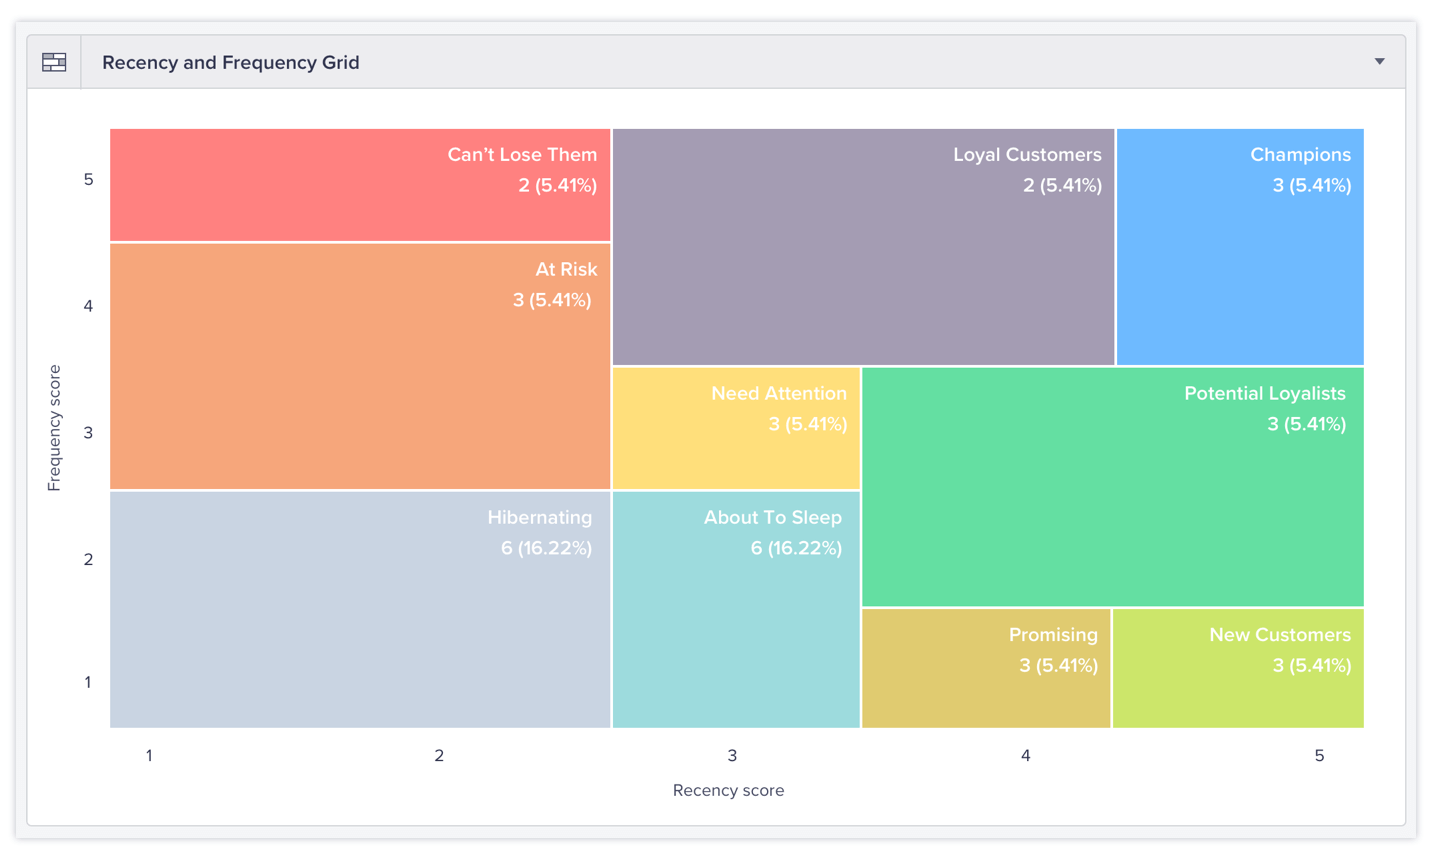

In [ ]:
#creation of segment variable
rfm_table['Segment'] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(seg_map, regex=True)

With "regex = True", we used the names like "need attention", "can't lose" instead of RFM scores to the data set.

In [ ]:
rfm_table.head()

In [ ]:
rfm_table[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

We grouped the rfm table according to the mean and count values of the segment variable.

## Remark: 

3 segments selected for evaluation are "Can't Lose", "Hibernating" and "Champions".

Number of customers for segments:

Can't Lose = 71, Hibernating = 1522, Champions = 852


- Can't Lose Segment;

    - The last shopping date of the customers is on average 353 days before.
    - Customers have made an average of 16 purchases.
    - Customers spent an average of £ 8356.


- Hibernating Segment;

    - The last shopping date of the customers is 481 days before average.
    - Customers made an average of 1 purchases.
    - Customers spent an average of £ 438.


- Champions Segment;

    - The last shopping date of the customers is 30 days before average.
    - Customers made an average of 19 purchases.
    - Customers spent an average of £ 10796.


- Can't Lose Segment;

    - Customers in this segment have not recently made a purchase. For this reason, we need to prepare a discount and gift campaign for this segment. These customers made a large number of purchases when they made purchases before. However, recency values are lower than they should be. The campaign to be implemented for these customers should include both items purchased and recommendations based on previous activities. New and popular products associated with the products that they were interested in can also be included in this campaign. Situations that will cause these customers to stop buying need to be investigated.


- Hibernating Segment;

    - Customers in this segment have not made a purchase for a long time. However, by offering discounts, they may be attracted to another purchase.


- Champions Segment;

    - Customers in this segment are responsible for most of the revenue. Campaigns should be implemented to ensure the continuity of the shopping of these customers.

Resources;
- https://docs.exponea.com/docs/rfm-segmentation

- Recency and Frequency Grid Image: https://clevertap.com/blog/automate-user-segmentation-with-rfm-analysis/